In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from preprocesor import *
import numpy as np
import warnings
warnings.filterwarnings('ignore')

lag = 4
diff_periods = 1

df = pd.read_excel('Consumo_energetico.xlsx')
maxval = df.consumo.max()
# df['consumo'] = df.consumo / maxval
df['consumo'] = scale(df['consumo'])

p1 = PreprocessDifferenciate(periods=diff_periods)
p2 = PreprocessLagMatrix(lag)
p3 = PreprocessRemoveFirstElements(lag + diff_periods)
pl = PreprocessList([p1, p2, p3])

x, y = pl.execute(df.consumo)
x.head(10)

,consumo_t-1,consumo_t-2,consumo_t-3,consumo_t-4
5,0.138256,-0.615670,-0.074865,-0.670556
6,-0.285859,0.138256,-0.615670,-0.074865
7,0.158392,-0.285859,0.138256,-0.615670
8,0.254679,0.158392,-0.285859,0.138256
9,-0.444149,0.254679,0.158392,-0.285859
10,0.426195,-0.444149,0.254679,0.158392
11,0.365690,0.426195,-0.444149,0.254679
12,0.390539,0.365690,0.426195,-0.444149
13,0.018056,0.390539,0.365690,0.426195
14,-0.626189,0.018056,0.390539,0.365690


In [2]:
y.head()

5   -0.285859
6    0.158392
7    0.254679
8   -0.444149
9    0.426195
Name: consumo, dtype: float64

In [3]:
l = list(x.columns)
l

['consumo_t-1', 'consumo_t-2', 'consumo_t-3', 'consumo_t-4']

In [4]:
def eval_model(model, last_observation, times=1):
    y_pred_list = []
    x = last_observation
    def predict(model, val, list):
        y = model.predict(val.reshape([1,-1]))
        list.append(y)

    predict(model, x, y_pred_list)
    for i in range(times):
        # si el ultimo valor es 5; el vector x con valores [1,2,3,4] se convierte en [5,1,2,3]
        x = np.append(y_pred_list[-1], x[:-1])
        predict(model, x, y_pred_list)

    return np.array(y_pred_list)    

In [5]:

xtrain, xtest, ytrain, ytest = train_test_split(x, y, shuffle=False, test_size=0.1)

svm = SVR(gamma=1.2)
svm.fit(xtrain, ytrain)
score = svm.score(xtest, ytest)
ypred = svm.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score,mse))

score:0.7524289476527678
mse:0.07580720768425336


In [6]:
X = xtrain.values.reshape(xtrain.shape[0], 1, xtrain.shape[1])
X.shape

(467, 1, 4)

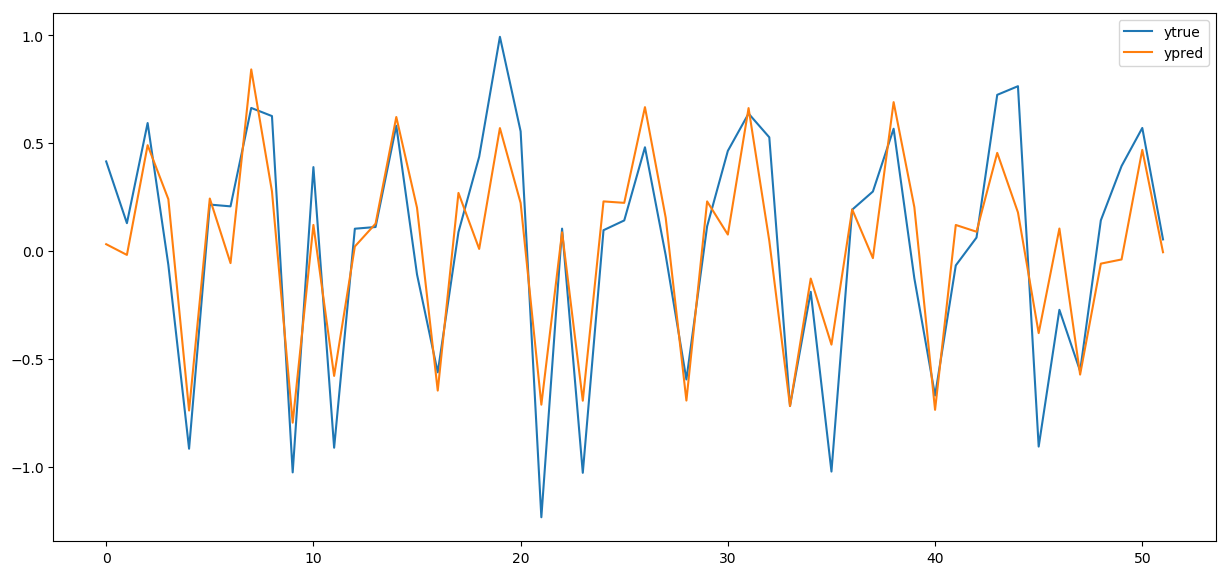

In [7]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

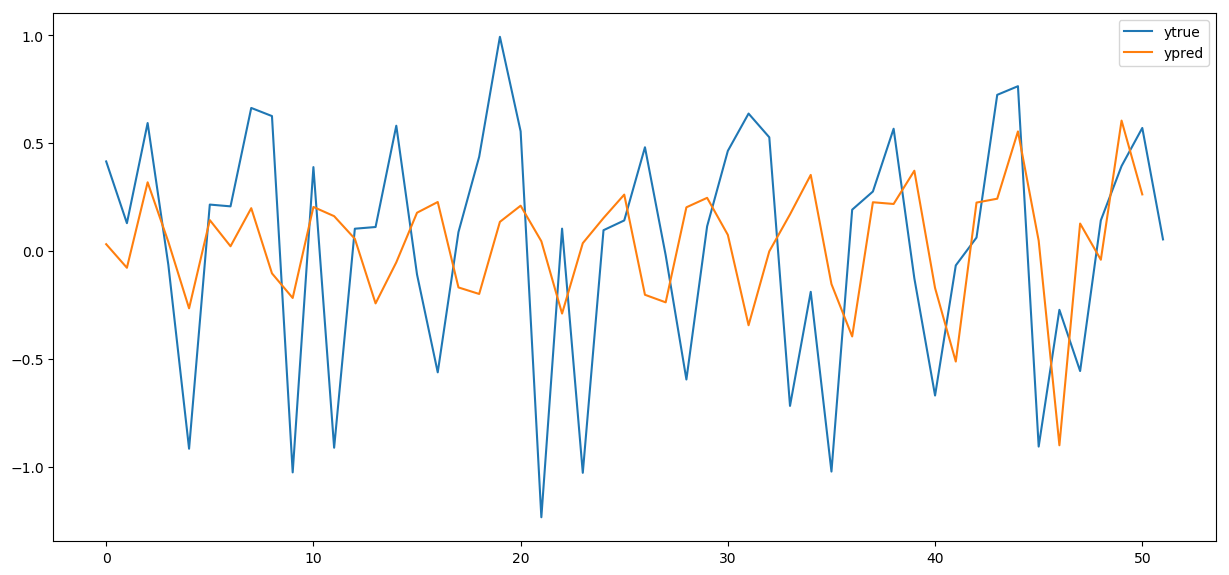

In [8]:
ypred = eval_model(svm, xtest.iloc[0], 50)
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import *
from sklearn.metrics import r2_score

np.random.seed(7)
model = Sequential()
model.add(Dense(units=16, activation='tanh', input_dim=lag))
model.add(Dropout(0.05))
model.add(Dense(units=1, activation='linear'))
#opt = SGD(lr=0.01, momentum=0.2, decay=0.01)
opt = Adam(lr=0.01, decay=0.01)
model.compile(loss='mse',
              optimizer=opt)

model.fit(xtrain, ytrain, epochs=100, batch_size=64, verbose=0, shuffle=False);
ypred = model.predict(xtest)

Using CNTK backend


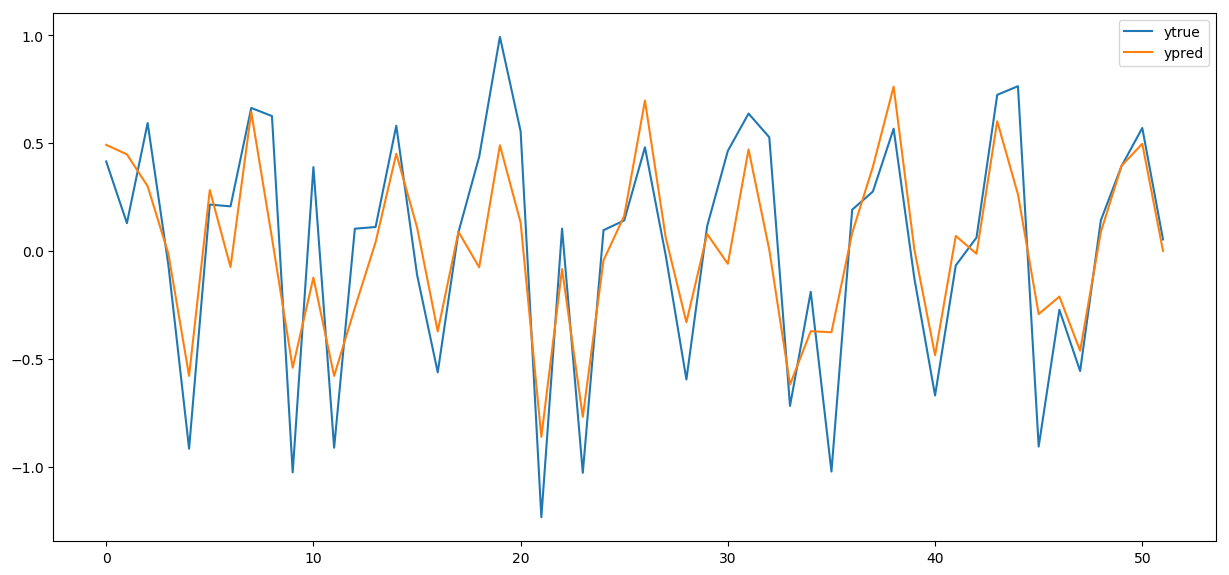

In [10]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [11]:
score = r2_score(ytest, ypred)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score,mse))

score:0.7183458231282516
mse:0.08624359140061137


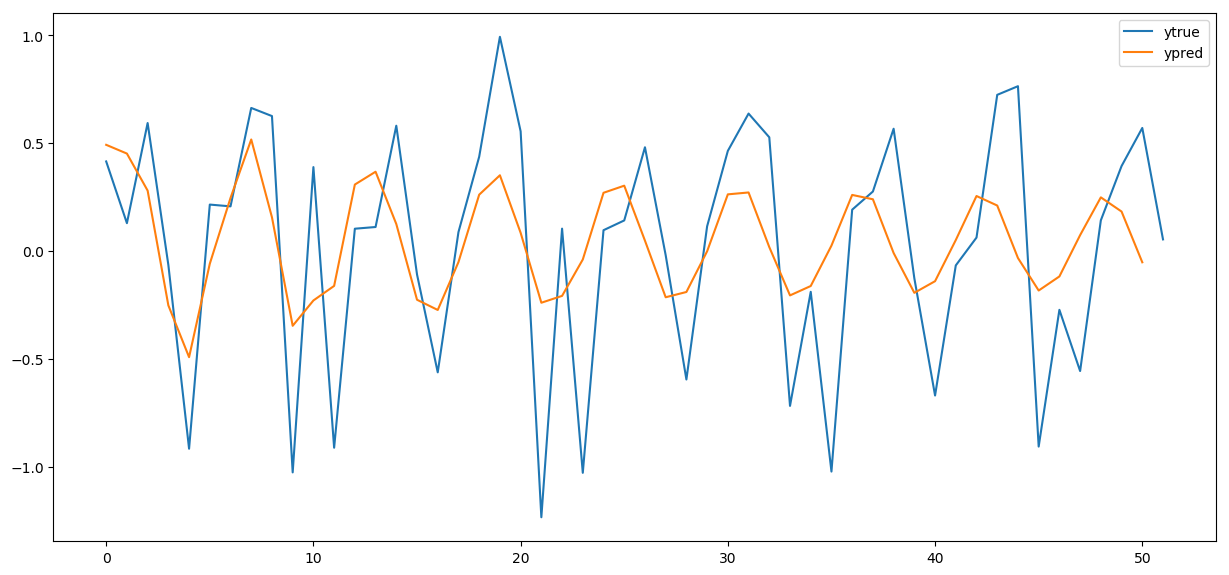

In [12]:
ypred=eval_model(model, xtest.iloc[0], 50).reshape([-1])
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [13]:
from sklearn.neural_network import MLPRegressor

np.random.seed(10)
regresor = MLPRegressor(hidden_layer_sizes=(10,10,8), activation='tanh', solver='lbfgs', shuffle=False, max_iter=100)
regresor.fit(xtrain, ytrain)
score = regresor.score(xtest, ytest)
ypred = regresor.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score, mse))

score:0.6727562201386466
mse:0.10020330304423429


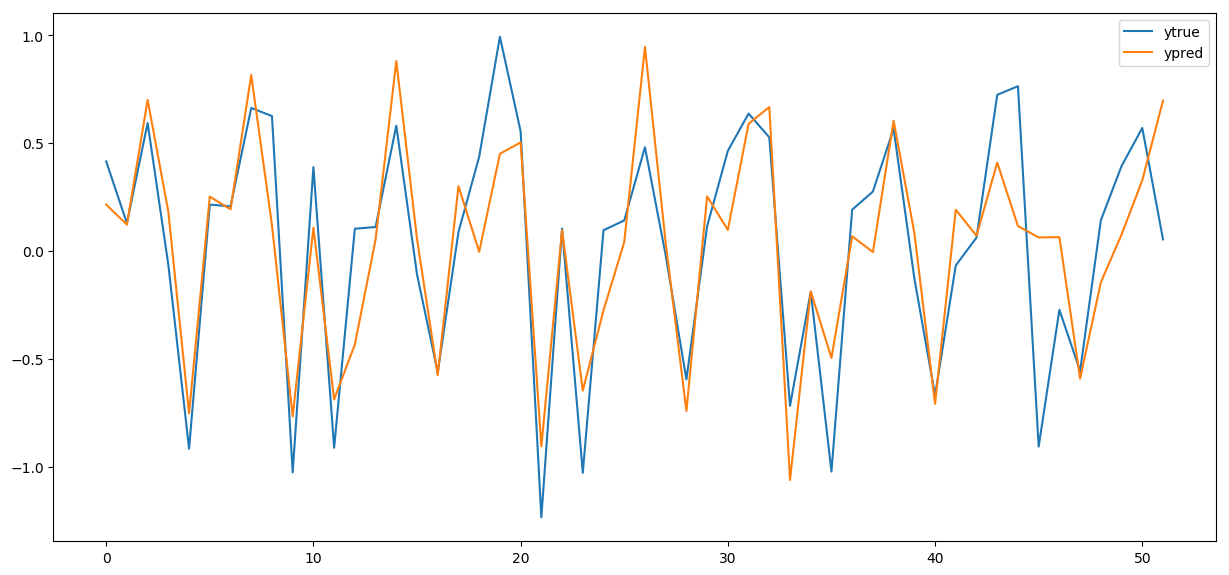

In [14]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

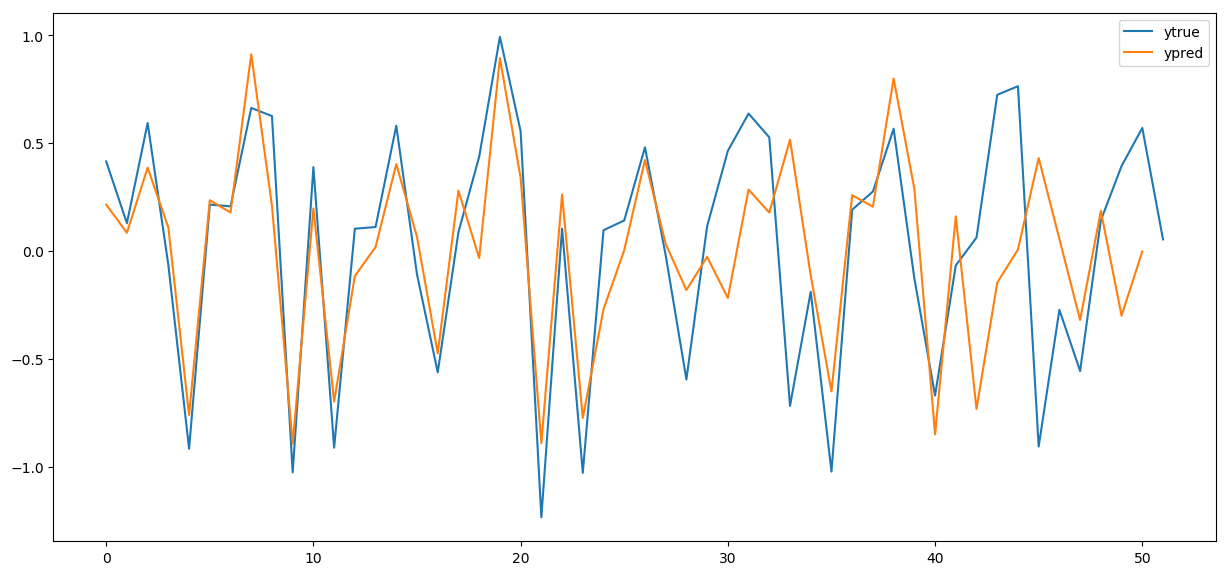

In [15]:
ypred=eval_model(regresor, xtest.iloc[0], 50).reshape([-1])
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [16]:
import xgboost as xgb

gbm = xgb.XGBRegressor(max_depth=6, n_estimators=200, reg_lambda=0.9)
gbm.fit(xtrain, ytrain)
ypred = gbm.predict(xtest)

score = r2_score(ytest, ypred)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score,mse))

score:0.7867265269949414
mse:0.06530515707854416


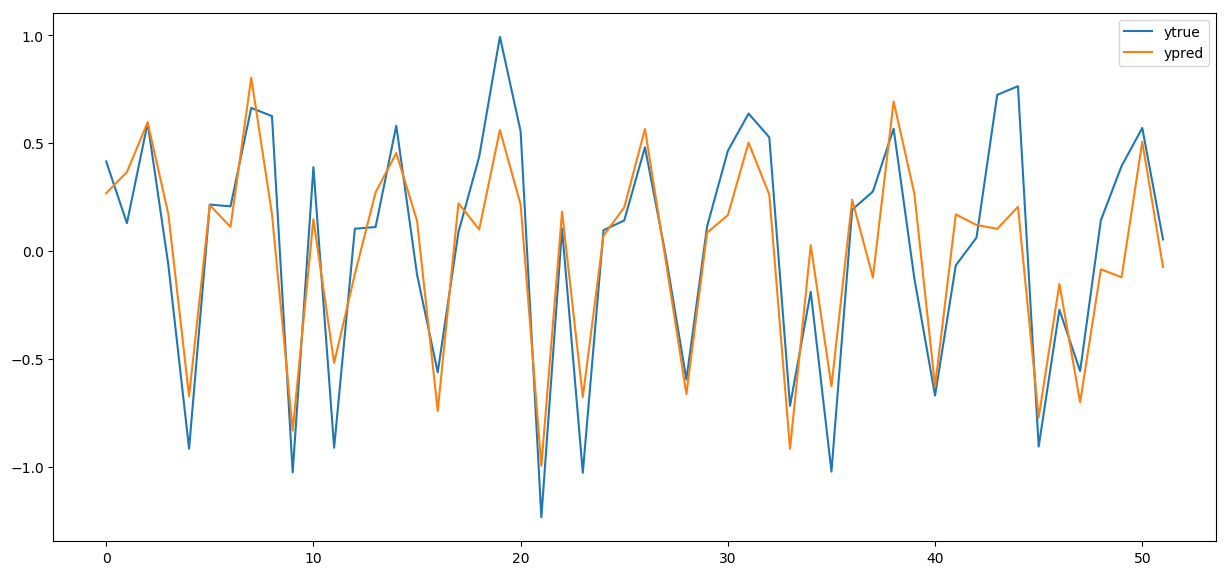

In [17]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

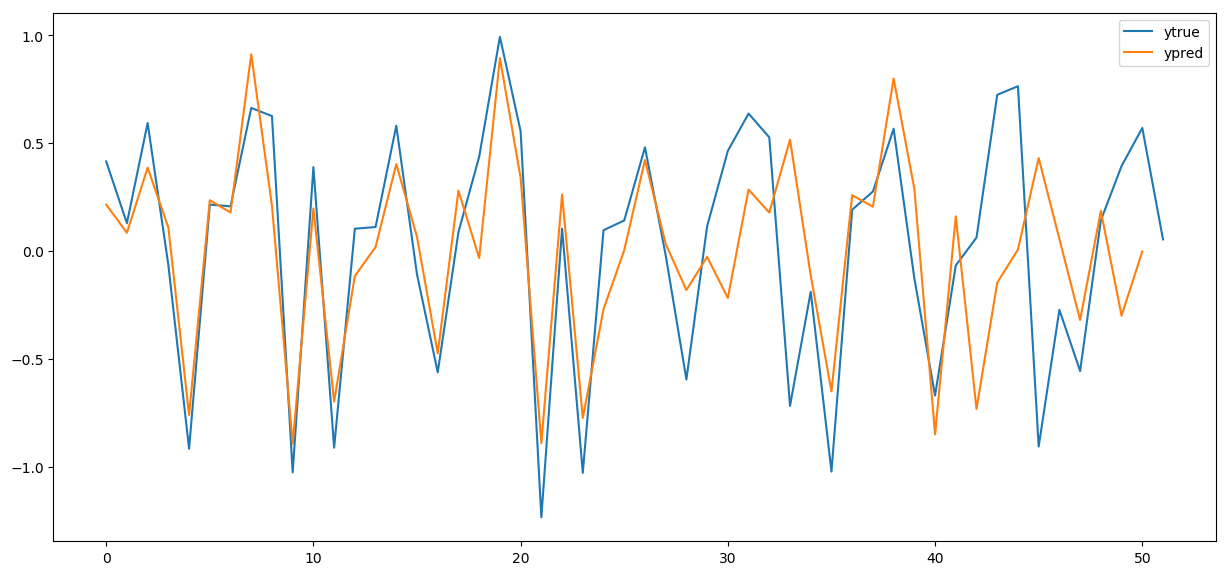

In [18]:
ypred=eval_model(regresor, xtest.iloc[0], 50).reshape([-1])
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()